# 09 HOG SVM Classical CV

In [1]:
# Import librerie
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms

# Scikit-learn per preprocessing e metriche
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Impostazioni
np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Device: {device}")
print(f"CUDA disponibile: {torch.cuda.is_available()}")

import os, urllib.request

# GitHub Release URL for pretrained weights
WEIGHTS_BASE_URL = os.environ.get('WEIGHTS_URL', 'https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/')
WEIGHTS_DIR = '../pretrained_weights'
os.makedirs(WEIGHTS_DIR, exist_ok=True)

def load_or_train(model, train_fn, weights_filename, device='cpu'):
    """Load pretrained weights if available, otherwise train and save.
    Also saves/loads training history as JSON alongside weights."""
    weights_path = os.path.join(WEIGHTS_DIR, weights_filename)
    history_path = weights_path.replace('.pt', '_history.json')

    def _load_history():
        if os.path.exists(history_path):
            import json as _json
            with open(history_path, 'r') as f:
                return _json.load(f)
        return None

    if os.path.exists(weights_path):
        model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
        print(f"Loaded pretrained weights from {weights_path}")
        return _load_history()
    elif WEIGHTS_BASE_URL:
        try:
            url = WEIGHTS_BASE_URL + weights_filename
            urllib.request.urlretrieve(url, weights_path)
            # Also try downloading history
            try:
                urllib.request.urlretrieve(
                    WEIGHTS_BASE_URL + weights_filename.replace('.pt', '_history.json'), history_path)
            except Exception:
                pass
            model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
            print(f"Downloaded and loaded weights from {url}")
            return _load_history()
        except Exception as e:
            print(f"Could not download weights: {e}. Training from scratch...")

    history = train_fn()
    torch.save(model.state_dict(), weights_path)
    print(f"Saved weights to {weights_path}")
    if history is not None:
        import json as _json
        with open(history_path, 'w') as f:
            _json.dump(history, f)
        print(f"Saved training history to {history_path}")
    return history

PyTorch version: 2.10.0+cu128
Torchvision version: 0.25.0+cu128
Device: cuda
CUDA disponibile: True


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 457kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.7MB/s]


Training set: (60000, 28, 28)
Test set: (10000, 28, 28)

Range valori pixel: [0, 255]
Classi: [0 1 2 3 4 5 6 7 8 9]


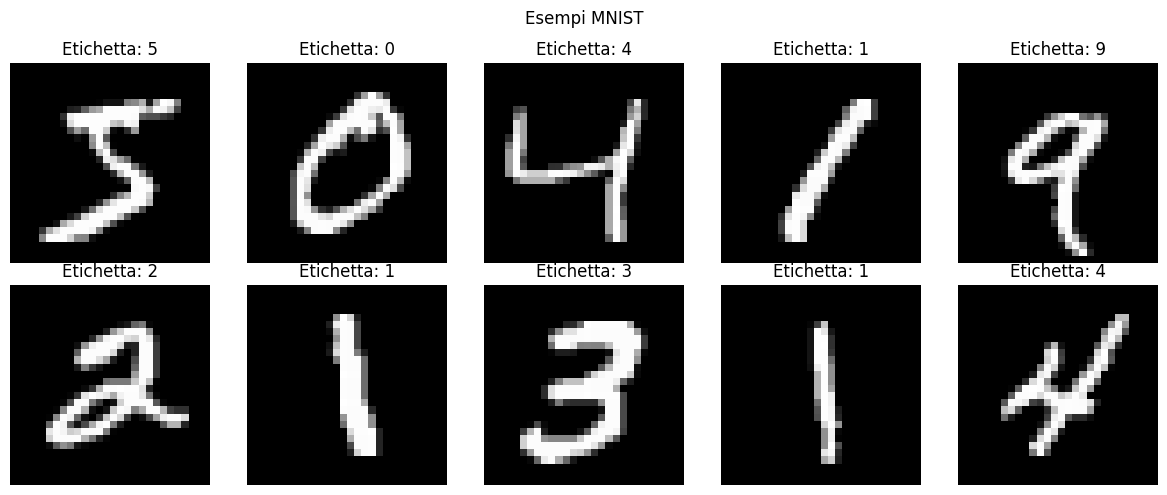

In [2]:
# Caricamento MNIST da torchvision
mnist_train = torchvision.datasets.MNIST(root='../data', train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root='../data', train=False, download=True)

X_train = mnist_train.data.numpy()  # (60000, 28, 28)
y_train = mnist_train.targets.numpy()
X_test = mnist_test.data.numpy()
y_test = mnist_test.targets.numpy()

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nRange valori pixel: [{X_train.min()}, {X_train.max()}]")
print(f"Classi: {np.unique(y_train)}")

# Visualizzazione esempi
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f"Etichetta: {y_train[i]}")
    ax.axis('off')
plt.suptitle('Esempi MNIST')
plt.tight_layout()
plt.show()

In [3]:
# Flatten: da (28, 28) a (784,)
X_train_flat = X_train.reshape(-1, 28 * 28)
X_test_flat = X_test.reshape(-1, 28 * 28)

print(f"Shape dopo flatten:")
print(f"  Training: {X_train_flat.shape}")
print(f"  Test: {X_test_flat.shape}")

# Normalizzazione
X_train_norm = X_train_flat / 255.0
X_test_norm = X_test_flat / 255.0

print(f"\nRange dopo normalizzazione: [{X_train_norm.min():.2f}, {X_train_norm.max():.2f}]")

Shape dopo flatten:
  Training: (60000, 784)
  Test: (10000, 784)

Range dopo normalizzazione: [0.00, 1.00]


---

## 6. Introduzione alla Computer Vision

La **Computer Vision** è il campo dell'AI che permette ai computer di "vedere" e interpretare immagini.

### 6.1 Rappresentazione Digitale delle Immagini

Un'immagine digitale è una matrice di pixel:

- **Grayscale**: matrice 2D (altezza × larghezza), valori 0-255
- **RGB**: matrice 3D (altezza × larghezza × 3 canali)
  - Canale Rosso (R)
  - Canale Verde (G)
  - Canale Blu (B)

### 6.2 Task Principali di Computer Vision

1. **Image Classification**: assegnare una label all'immagine
2. **Object Detection**: localizzare e classificare oggetti multipli
3. **Semantic Segmentation**: classificare ogni pixel
4. **Instance Segmentation**: segmentare singole istanze di oggetti
5. **Face Recognition**: identificare persone
6. **Pose Estimation**: rilevare posizioni corporee

### 6.3 Evoluzione della Computer Vision

**Era Pre-Deep Learning (fino al 2012):**
- Feature engineering manuale
- SIFT, HOG, SURF
- Classificatori tradizionali (SVM, Random Forest)

**Era Deep Learning (2012-oggi):**
- CNN apprendono feature automaticamente
- Transfer Learning con modelli pre-trained
- State-of-the-art: Vision Transformers

---

## 7. Progetto di Computer Vision Classico

Prima dell'era del deep learning, i progetti di CV seguivano questa pipeline:

```
Immagine → Feature Extraction → Classificatore ML → Predizione
```

Implementeremo un classificatore di cifre usando feature estratte manualmente.

### 7.1 Feature Extraction: HOG (Histogram of Oriented Gradients)

**HOG** descrive un'immagine attraverso la distribuzione delle direzioni dei gradienti:
1. Calcola gradienti dei pixel
2. Divide l'immagine in celle
3. Crea istogramma delle direzioni dei gradienti per cella
4. Normalizza

Dimensione feature vector HOG: 144


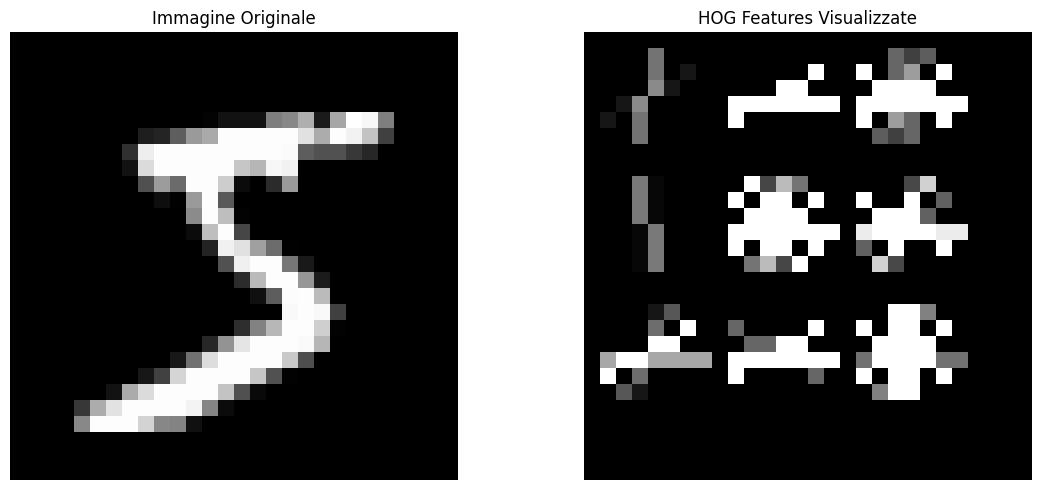

In [18]:
from skimage.feature import hog
from skimage import exposure

# Estrazione HOG features da un'immagine
sample_img = X_train[0]

# Calcola HOG
features, hog_image = hog(
    sample_img,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True
)

print(f"Dimensione feature vector HOG: {len(features)}")

# Visualizzazione
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(sample_img, cmap='gray')
axes[0].set_title('Immagine Originale')
axes[0].axis('off')

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
axes[1].imshow(hog_image_rescaled, cmap='gray')
axes[1].set_title('HOG Features Visualizzate')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### 7.2 Estrazione Feature per tutto il Dataset

In [19]:
def extract_hog_features(images):
    """
    Estrae HOG features da un array di immagini.
    """
    features_list = []

    for img in images:
        features = hog(
            img,
            orientations=9,
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=False
        )
        features_list.append(features)

    return np.array(features_list)


# Estrazione per un subset (per velocità)
print("Estrazione HOG features...")
n_samples = 10000

X_train_hog = extract_hog_features(X_train[:n_samples])
X_test_hog = extract_hog_features(X_test[:2000])
y_train_subset = y_train[:n_samples]
y_test_subset = y_test[:2000]

print(f"Shape HOG features training: {X_train_hog.shape}")
print(f"Shape HOG features test: {X_test_hog.shape}")
print("Estrazione completata")

Estrazione HOG features...
Shape HOG features training: (10000, 144)
Shape HOG features test: (2000, 144)
Estrazione completata


### 7.3 Classificazione con SVM

In [20]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Training SVM
print("Training SVM...")
svm_classifier = SVC(kernel='rbf', C=10, gamma='scale')
svm_classifier.fit(X_train_hog, y_train_subset)
print("Training completato")

# Predizioni
y_pred_svm = svm_classifier.predict(X_test_hog)

# Valutazione
accuracy_svm = accuracy_score(y_test_subset, y_pred_svm)
print(f"\nAccuracy SVM con HOG: {accuracy_svm:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_subset, y_pred_svm))

Training SVM...
Training completato

Accuracy SVM con HOG: 0.9455

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       175
           1       0.97      0.99      0.98       234
           2       0.93      0.98      0.96       219
           3       0.95      0.93      0.94       207
           4       0.94      0.94      0.94       217
           5       0.96      0.93      0.94       179
           6       0.93      0.95      0.94       178
           7       0.94      0.93      0.93       205
           8       0.91      0.91      0.91       192
           9       0.95      0.91      0.93       194

    accuracy                           0.95      2000
   macro avg       0.95      0.94      0.94      2000
weighted avg       0.95      0.95      0.95      2000



### 7.4 Confronto: Approccio Classico vs Deep Learning

Confronto Approcci (su 2000 campioni di test):
                     Approccio  Accuracy  Feature Engineering  Train Samples  Parametri
          HOG + SVM (Classico)    0.9455        Manuale (HOG)          10000    3124 SV
Neural Network (Deep Learning)    0.9655 Automatico (appreso)          60000 ~109K (NN)


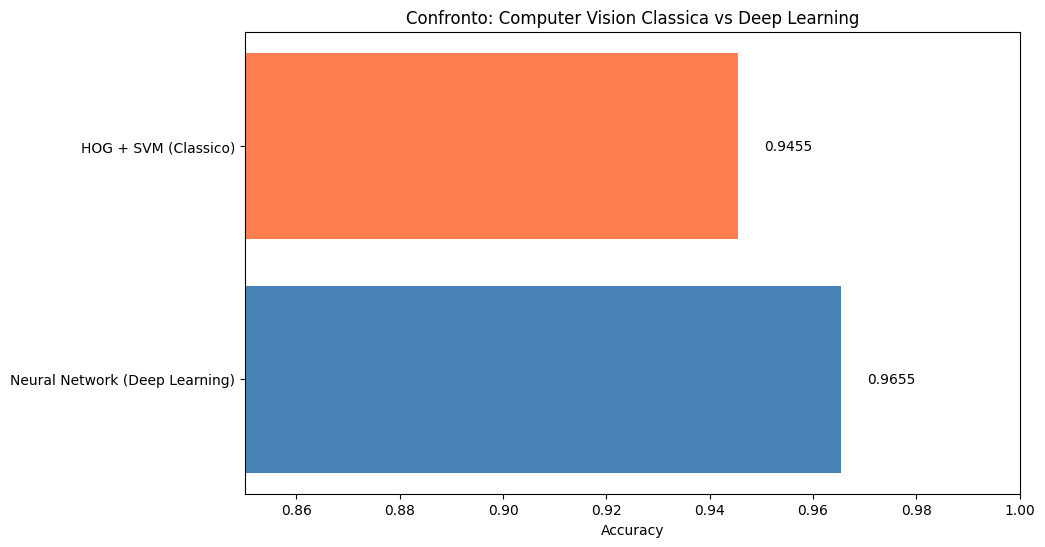

In [21]:
# Confronto sullo stesso test set (2000 campioni)
# NOTA: La NN e' stata addestrata su 60,000 campioni (MNIST completo),
# mentre l'SVM e' stato addestrato su ~10,000 campioni (subset HOG).
# Questo rende il confronto non perfettamente equo.
X_test_subset_tensor = torch.FloatTensor(X_test_norm[:2000]).to(device)
y_test_subset_tensor = torch.LongTensor(y_test[:2000]).to(device)

model.eval()
with torch.no_grad():
    outputs = model(X_test_subset_tensor)
    _, predicted = torch.max(outputs, 1)
    nn_accuracy_subset = (predicted == y_test_subset_tensor).sum().item() / len(y_test_subset_tensor)

# Confronto performance
confronto = pd.DataFrame({
    'Approccio': ['HOG + SVM (Classico)', 'Neural Network (Deep Learning)'],
    'Accuracy': [accuracy_svm, nn_accuracy_subset],
    'Feature Engineering': ['Manuale (HOG)', 'Automatico (appreso)'],
    'Train Samples': [10000, 60000],
    'Parametri': [f'{svm_classifier.n_support_.sum()} SV', '~109K (NN)']
})

print("Confronto Approcci (su 2000 campioni di test):")
print(confronto.to_string(index=False))

# Visualizzazione
plt.figure(figsize=(10, 6))
plt.barh(confronto['Approccio'], confronto['Accuracy'], color=['coral', 'steelblue'])
plt.xlabel('Accuracy')
plt.title('Confronto: Computer Vision Classica vs Deep Learning')
plt.xlim([0.85, 1.0])
for i, v in enumerate(confronto['Accuracy']):
    plt.text(v + 0.005, i, f'{v:.4f}', va='center')
plt.gca().invert_yaxis()
plt.show()

**Osservazioni:**

1. **Performance**: Le reti neurali tipicamente superano gli approcci classici su dataset complessi
2. **Feature Engineering**: DL elimina il bisogno di feature engineering manuale
3. **Dati**: DL richiede più dati, approcci classici possono funzionare con dataset piccoli
4. **Interpretabilità**: HOG + SVM è più interpretabile
5. **Computazione**: DL richiede più risorse (GPU)

---